# Pattern exploration
---

In [211]:
from IPython.display import SVG
import numpy as np
import pickle
from scipy import sparse

from sknetwork.data import load_netset
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees
from sknetwork.visualization import svg_graph

In [212]:
def preprocess_data(biadjacency, names_col, s):
    # Frequent attributes
    freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

    # Filter data with index
    biadjacency = biadjacency[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Sort data
    sort_index = np.argsort(freq_attribute)
    sorted_biadjacency = biadjacency[:, sort_index]
    words = words[sort_index]
    return sorted_biadjacency, words

def get_pattern(patterns, i):
    return patterns[i][0], patterns[i][1]

def display_pattern(adjacency, nodes, names, labels):
    return SVG(svg_graph(adjacency[nodes, :][:, nodes] + sparse.identity(len(nodes)), names=names[nodes], labels=labels[nodes]))

## Parameters  

Select:
- dataset: either `wikivitals`, `wikivitals-fr` or `wikischools`
- $s$ and $\beta$: support parameters (here 5)
- order_attributes: initial ordering of attributes (here True)

In [213]:
# Parameters for UnexPatterns
dataset = 'wikivitals'
s = 5
beta = 5
order_attributes = True

**Load graph data and preprocess it (e.g attribute ordering)**

In [214]:
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
names_col = graph.names_col
labels = graph.labels

# Preprocess data (get same attribute order as in UnexPattern)
new_biadjacency, words = preprocess_data(biadjacency, names_col, s)

Parsing files...
Done.


**Load `UnexPatterns` output**

Output of algorithm is a list of patterns, i.e. a list of tuples (nodes, attributes).

In [215]:
with open(f'result_{dataset}_{beta}_{s}_order{str(order_attributes)}.bin', 'rb') as data:
    res = pickle.load(data)

In [216]:
print(f'Number of patterns found: {len(res)}')

Number of patterns found: 1116


In [217]:
# First pattern (pattern of index 0 is the starting point of lattice)
idx = 1 #np.random.choice(len(res))
print(res[idx])

nodes = res[idx][0]
attributes = res[idx][1]
print(names[nodes], words[attributes])

([1263, 1322, 1895, 7471, 7571], [45, 7520, 17492, 17608, 17973])
['Brown' 'CMYK color model' 'Color' 'RGB color model' 'Red'] ['cmyk' 'RGB' 'red' 'color' 'model']


**Display pattern**

Pattern index: 452
Attributes: ['Presley' 'Elvis' 'singer' 'song' 'artist' 'music' 'record' 'popular']


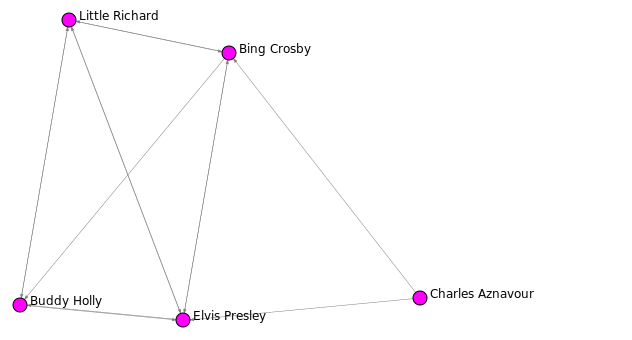

In [193]:
# Random pattern
idx = np.random.choice(len(res))
nodes, attributes = get_pattern(res, idx)

print(f'Pattern index: {idx}')
print(f'Attributes: {words[attributes]}')

# Display pattern
display_pattern(adjacency, nodes, names, labels)

## Patterns from keywords

Select pattern related to specific keywords, i.e. patterns that contain **at least one** keyword in list.

In [194]:
def get_patterns(patterns, keyword, words):
    res = []
    for p in patterns:
        for w in keywords:
            index = np.argwhere(words==w)
            if len(index) > 0:
                if int(index) in p[1]:
                    res.append(p)
                    break
            else:
                raise Exception(f'keyword: {w} is not found.')
    return res

In [195]:
valid_words = np.unique(np.asarray([words[w] for p in res for w in p[1]]))
print(len(valid_words))

1074


In [196]:
# Select keywords
#print(f'Some random words to get inspiration: {np.random.choice(words, 15)}')
print(f'Some random words to get inspiration: {np.random.choice(valid_words, 15)}')

Some random words to get inspiration: ['partner' 'genocide' 'Franks' 'God' 'Series' 'House' 'Hubble' 'white'
 'nonsocial' 'STI' 'coach' 'day' 'superalloy' 'biological' 'gold']


In [197]:
# Chose keywords
keywords = ['constellation', 'Oxford']

In [198]:
kw_patterns = get_patterns(res, keywords, words)
print(f'Number of patterns related to {keywords}: {len(kw_patterns)}')

Number of patterns related to ['constellation', 'Oxford']: 2


Attributes of patter: ['kiloparsec' 'constellation' 'Milky' 'Way' 'galaxy' 'star' 'Earth']


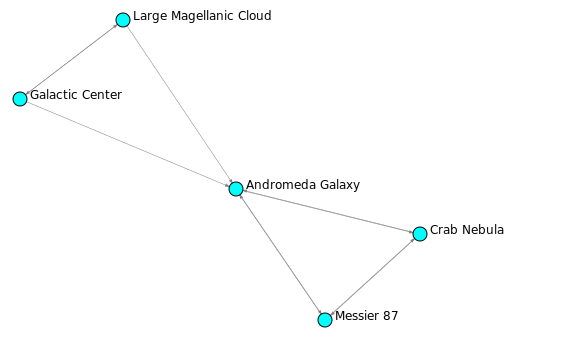

In [199]:
first_pattern = get_pattern(kw_patterns, 0)

print(f'Attributes of patter: {words[first_pattern[1]]}')
display_pattern(adjacency, first_pattern[0], names, labels)

Attributes of pattern 0/1: ['kiloparsec' 'constellation' 'Milky' 'Way' 'galaxy' 'star' 'Earth']


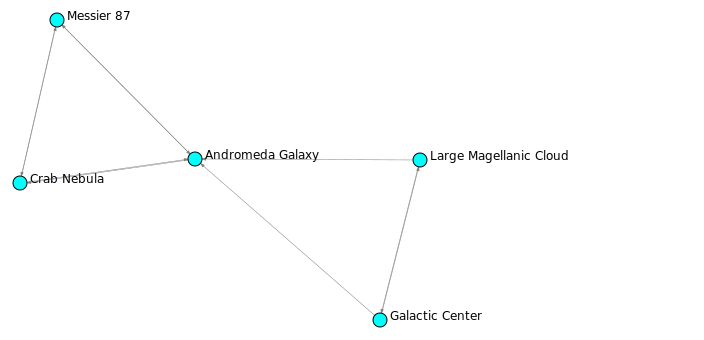

In [200]:
idx = np.random.choice(len(kw_patterns))
rand_pattern = get_pattern(kw_patterns, idx)

print(f'Attributes of pattern {idx}/{len(kw_patterns)-1}: {words[rand_pattern[1]]}')
display_pattern(adjacency, rand_pattern[0], names, labels)

## Pattern summaries from keywords 

In [201]:
def get_summarized_graph(adjacency, patterns):
    """Get summarized graph given patterns and original adjacency matrix."""
    
    rows, cols = [], []

    for p in patterns:

        # exclude first element of lattice 
        if len(p[1]) > 0:
            nodes = sorted(p[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_pattern = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_pattern.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_pattern.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def get_summarized_biadjacency(adjacency, biadjacency, patterns):
    summarized_biadj = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
    for p in patterns:
        if len(p[1]) > 0:
            for node in p[0]:
                summarized_biadj[node, p[1]] += 1

    summarized_biadj = sparse.csr_matrix(summarized_biadj.astype(bool), shape=summarized_biadj.shape)
    return summarized_biadj

In [202]:
def display_pattern_summary(summarized_adjacency, summarized_biadjacency, mask, labels_cc, idx, names, names_col, labels):
    mask_cc = labels_cc == idx
    g = summarized_adjacency[mask, :][:, mask]
    g_cc = g[mask_cc, :][:, mask_cc]
    
    attributes = np.unique(summarized_biadj[mask, :][mask_cc, :].indices)
    print(f'Attributes: {names_col[attributes]}')
    
    return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=500, height=500, labels=labels[mask][mask_cc]))

**Summarized graph**

In [218]:
# Build summarized adjacency matrix, i.e. adjacency matrix of the union of all patterns found with UnexPatterns
summarized_adj = get_summarized_graph(adjacency, res)
summarized_adj

<10011x10011 sparse matrix of type '<class 'numpy.float64'>'
	with 3465 stored elements in Compressed Sparse Row format>

In [219]:
# Build summarized biadjacency matrix
summarized_biadj = get_summarized_biadjacency(adjacency, new_biadjacency, res)
summarized_biadj

<10011x18338 sparse matrix of type '<class 'numpy.bool_'>'
	with 9480 stored elements in Compressed Sparse Row format>

**Pattern summaries**

In [220]:
# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adj.dot(np.ones(summarized_adj.shape[1])))

# Number of connected components (NOT considering isolated nodes)
labels_cc_summarized = get_connected_components(summarized_adj[mask, :][:, mask])
nb_cc = len(np.unique(labels_cc_summarized)) 

print(f'Number of pattern summaries: {nb_cc}')

Number of pattern summaries: 101


Pattern summary: 67
Attributes: ['chordophone' 'stringed' 'Hornbostel' 'Sachs' 'pluck' 'finger' 'string'
 'classification' 'player' 'instrument' 'musical' 'sound' 'music'
 'classical' 'play']


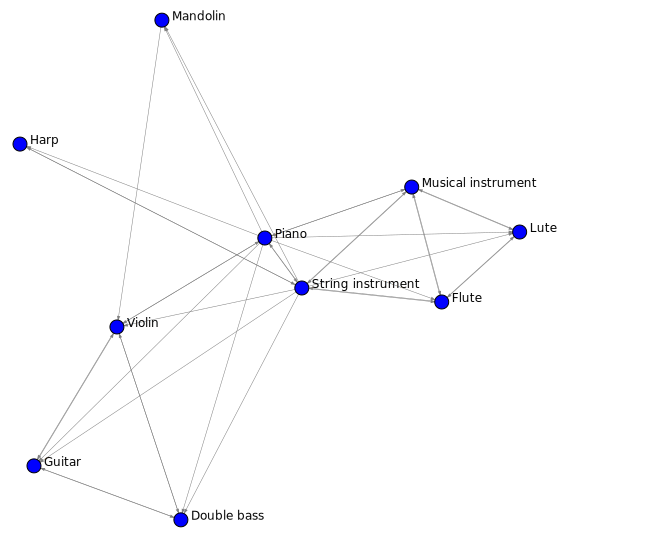

In [227]:
# Display random pattern summary
idx = np.random.choice(nb_cc)
print(f'Pattern summary: {idx}')
display_pattern_summary(summarized_adj, summarized_biadj, mask, labels_cc_summarized, idx, names, words, labels)